In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import codecs
from sklearn import mixture, metrics
import glob
import pickle
from tabulate import tabulate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
lang_list=['asm','ben','eng','guj','hin','kan', 'mal', 'mar', 'odi', 'pun', 'tam', 'tel']

In [ ]:

def get_feature(fpath,lang,n_files):
  path = r'/content/drive/MyDrive/PRA2_data/extracted/'+lang+'/'+ fpath 
  # print(path)
  all_files = glob.glob(path + "/*.csv")
#   print(all_files)
  mfcc_feature = np.empty([0,39])
  count = 0
  for filename in all_files:
    if count < n_files: # training using subset of 100 files per langauage
      vectors = list(csv.reader(codecs.open(filename, 'rU', 'utf-16')))
      mfcc_feature=np.concatenate((mfcc_feature,vectors),axis=0)
      count+=1
    else:
      break
  print("Training Feature Collection for " + lang+ ": " ,mfcc_feature.shape)
  return mfcc_feature

In [ ]:

def train_gmm(path,features,k_comp,cov):
  gmm_model = mixture.GaussianMixture(n_components=k_comp ,covariance_type=cov, max_iter=100, init_params='kmeans')
  gmm_model.fit(features)
  
   # dumping the trained gaussian model
  dest = r"/content/drive/MyDrive/PRA2_data/models_comp_"
  picklefile = path.split("/")[6]+".gmm"
  dest+=str(k_comp)+"/"
  pickle.dump(gmm_model,open(dest + picklefile,'wb'))
  print ('Modeling completed for language:',k_comp ,"components:",picklefile)

# Training / Modeling

### Training using subset of 100 samples per langauage

In [ ]:
n_comp=[2,4,8,16]
for lang in lang_list:
  path = r'/content/drive/MyDrive/PRA2_data/extracted/'+lang+'/PB_train'
  Mfcc_feature=get_feature('PB_train',lang,100)
  for k in n_comp:
      train_gmm(path,Mfcc_feature,k,'diag')

Training Feature Collection for asm:  (11701, 39)
Modeling completed for language: 2 components: asm.gmm
Modeling completed for language: 4 components: asm.gmm
Modeling completed for language: 8 components: asm.gmm
Modeling completed for language: 16 components: asm.gmm
Training Feature Collection for ben:  (23882, 39)
Modeling completed for language: 2 components: ben.gmm
Modeling completed for language: 4 components: ben.gmm
Modeling completed for language: 8 components: ben.gmm
Modeling completed for language: 16 components: ben.gmm
Training Feature Collection for eng:  (35013, 39)
Modeling completed for language: 2 components: eng.gmm
Modeling completed for language: 4 components: eng.gmm
Modeling completed for language: 8 components: eng.gmm
Modeling completed for language: 16 components: eng.gmm
Training Feature Collection for guj:  (25756, 39)
Modeling completed for language: 2 components: guj.gmm
Modeling completed for language: 4 components: guj.gmm
Modeling completed for lang

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loading GMM Models

In [ ]:
def get_model(k):
  gmm_path = r'/content/drive/MyDrive/PRA2_data/models_comp_'+str(k)+'/'
  gmm_files = glob.glob(gmm_path + "/*.gmm")
  models = [pickle.load(open(gf,'rb')) for gf in gmm_files]
  return models


## Predicting


In [ ]:

def testmodel(fpath,lang,n_files,models):
  path = r'/content/drive/MyDrive/PRA2_data/extracted/'+lang+'/'+ fpath  
  all_files = glob.glob(path + "/*.csv")  
  pred_correct=0
  lang_pred=[0] * len(lang_list)
  count = 0
  for filename in all_files:
    if count<n_files: 
    
      mfcc_test_feature = np.empty([0,39])
      mfccs = list(csv.reader(codecs.open(filename, 'rU', 'utf-16')))
      mfcc_test_feature=np.concatenate((mfcc_test_feature,mfccs),axis=0)      
      # print(mfcc_test_feature.shape)
      count+=1
      log_likelihood = np.zeros(len(models))
      # print(log_likelihood)
      
     
      for i in range(len(models)):
        gmm    = models[i]         #checking with each model one by one
        scores = np.array(gmm.score_samples(mfcc_test_feature))        
        log_likelihood[i] = scores.sum()

      # print(log_likelihood)
      l_index = np.argmax(log_likelihood)
      lang_pred[l_index]+=1
      if lang_list[l_index]==lang:
        pred_correct+=1
      # print ("############################  Predicted Language - ", lang_list[l_index])
      # print ("############################  Actual Language - ", lang)        
      
    else:
      break 
  

  return pred_correct,count,lang_pred

## Result for 100 Prasar Bharti Data


### Mixture Models with 2 Components

In [ ]:
result_pb=[]
confusion_mat_pb=[]

model=get_model(2)
for l in lang_list:
  p,t,lang_pred=testmodel('PB_test',l,100,model)
  res=[l,p,t]
  confusion_mat_pb.append(lang_pred)
  result_pb.append(res)
  
pred_correct=0
total_samples=0
for p in result_pb:
  pred_correct+=p[1]
  total_samples+=p[2]

acc_pb_2= (pred_correct *100)/ total_samples
print("Accuracy for Mixture Models with 2 Components Prasar Bharti Data Samples: ",acc_pb_2 , " %")
print("******************************************************************")
print("Confusion Matrix for Prasar Bharti Data: ")
confusion_mat_pb


Accuracy for Mixture Models with 2 Components Prasar Bharti Data Samples:  65.75  %
******************************************************************
Confusion Matrix for Prasar Bharti Data: 


[[53, 0, 6, 0, 5, 4, 1, 0, 24, 0, 1, 6],
 [7, 81, 1, 1, 3, 0, 5, 0, 1, 0, 0, 1],
 [2, 0, 90, 0, 2, 2, 2, 0, 0, 0, 2, 0],
 [0, 0, 0, 84, 2, 0, 0, 0, 0, 2, 5, 7],
 [7, 1, 15, 17, 44, 2, 0, 3, 0, 5, 1, 5],
 [2, 1, 11, 7, 8, 46, 2, 1, 3, 1, 8, 10],
 [7, 2, 2, 5, 1, 6, 56, 1, 13, 0, 5, 2],
 [23, 0, 5, 0, 0, 0, 0, 72, 0, 0, 0, 0],
 [3, 1, 2, 2, 2, 0, 2, 0, 87, 1, 0, 0],
 [0, 0, 0, 46, 2, 0, 0, 0, 0, 52, 0, 0],
 [1, 7, 0, 0, 0, 1, 1, 1, 2, 0, 85, 2],
 [0, 1, 6, 21, 13, 5, 2, 1, 3, 1, 8, 39]]

### Mixture Models with 4 Components

In [ ]:
result_pb=[]
confusion_mat_pb=[]

model=get_model(4)
for l in lang_list:
  p,t,lang_pred=testmodel('PB_test',l,100,model)
  res=[l,p,t]
  confusion_mat_pb.append(lang_pred)
  result_pb.append(res)
  
# head = ["Language","Predicted Correctly","Total_Samples"]
# print(tabulate(result_pb, headers=head, tablefmt="grid"))

pred_correct=0
total_samples=0
for p in result_pb:
  pred_correct+=p[1]
  total_samples+=p[2]

acc_pb_4= (pred_correct *100)/ total_samples
print("Accuracy for Mixture Models with 4 Components Prasar Bharti Data Samples: ",acc_pb_4 , " %")
print("******************************************************************")
print("Confusion Matrix for Prasar Bharti Data: ")
confusion_mat_pb


Accuracy for Mixture Models with 4 Components Prasar Bharti Data Samples:  67.75  %
******************************************************************
Confusion Matrix for Prasar Bharti Data: 


[[59, 1, 7, 0, 3, 2, 1, 1, 21, 0, 2, 3],
 [10, 79, 1, 1, 3, 0, 5, 0, 1, 0, 0, 0],
 [3, 0, 89, 0, 2, 0, 2, 1, 1, 0, 1, 1],
 [0, 0, 0, 82, 4, 0, 0, 0, 0, 1, 6, 7],
 [3, 1, 18, 14, 50, 0, 1, 5, 0, 6, 1, 1],
 [3, 1, 10, 5, 8, 57, 1, 0, 3, 0, 6, 6],
 [11, 0, 2, 4, 1, 2, 61, 1, 13, 0, 3, 2],
 [30, 0, 5, 0, 0, 0, 0, 65, 0, 0, 0, 0],
 [4, 1, 3, 1, 3, 0, 2, 0, 85, 0, 0, 1],
 [0, 0, 0, 42, 6, 0, 0, 0, 0, 52, 0, 0],
 [1, 8, 0, 0, 0, 0, 1, 1, 2, 0, 85, 2],
 [0, 2, 9, 13, 12, 2, 2, 1, 4, 0, 6, 49]]

### Mixture Models with 8 Components

In [ ]:
result_pb=[]
confusion_mat_pb=[]

model=get_model(8)
for l in lang_list:
  p,t,lang_pred=testmodel('PB_test',l,100,model)
  res=[l,p,t]
  confusion_mat_pb.append(lang_pred)
  result_pb.append(res)
  
# head = ["Language","Predicted Correctly","Total_Samples"]
# print(tabulate(result_pb, headers=head, tablefmt="grid"))

pred_correct=0
total_samples=0
for p in result_pb:
  pred_correct+=p[1]
  total_samples+=p[2]

acc_pb_8= (pred_correct *100)/ total_samples
print(" Accuracy for Mixture Models with 8 Components Prasar Bharti Data Samples:  ",acc_pb_8 , " %")
print("******************************************************************")
print("Confusion Matrix for Prasar Bharti Data: ")
confusion_mat_pb


 Accuracy for Mixture Models with 8 Components Prasar Bharti Data Samples:   70.91666666666667  %
******************************************************************
Confusion Matrix for Prasar Bharti Data: 


[[63, 1, 5, 0, 2, 0, 0, 3, 21, 0, 2, 3],
 [7, 83, 0, 1, 4, 2, 2, 0, 0, 0, 0, 1],
 [3, 0, 90, 0, 2, 0, 3, 0, 0, 0, 0, 2],
 [0, 0, 0, 87, 3, 0, 0, 1, 0, 1, 3, 5],
 [3, 1, 13, 8, 66, 0, 1, 4, 0, 1, 0, 3],
 [3, 0, 11, 6, 7, 55, 0, 0, 4, 0, 2, 12],
 [12, 2, 3, 4, 1, 1, 59, 0, 15, 0, 2, 1],
 [32, 0, 2, 0, 0, 0, 2, 64, 0, 0, 0, 0],
 [3, 1, 2, 0, 3, 0, 0, 0, 87, 1, 0, 3],
 [0, 0, 0, 40, 7, 0, 0, 0, 0, 52, 0, 1],
 [0, 7, 0, 0, 1, 1, 1, 0, 3, 0, 86, 1],
 [0, 1, 5, 14, 11, 0, 2, 2, 2, 0, 4, 59]]

### Mixture Models with 16 Components

In [ ]:
result_pb=[]
confusion_mat_pb=[]

model=get_model(16)
for l in lang_list:
  p,t,lang_pred=testmodel('PB_test',l,100,model)
  res=[l,p,t]
  confusion_mat_pb.append(lang_pred)
  result_pb.append(res)
  
# head = ["Language","Predicted Correctly","Total_Samples"]
# print(tabulate(result_pb, headers=head, tablefmt="grid"))

pred_correct=0
total_samples=0
for p in result_pb:
  pred_correct+=p[1]
  total_samples+=p[2]

acc_pb_16= (pred_correct *100)/ total_samples
print("Accuracy for Mixture Models with 16 Components Prasar Bharti Data Samples: ",acc_pb_16 , " %")
print("******************************************************************")
print("Confusion Matrix for Prasar Bharti Data: ")
confusion_mat_pb


Accuracy for Mixture Models with 16 Components Prasar Bharti Data Samples:  73.83333333333333  %
******************************************************************
Confusion Matrix for Prasar Bharti Data: 


[[70, 1, 6, 0, 1, 0, 1, 1, 17, 0, 2, 1],
 [4, 88, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2],
 [1, 0, 92, 0, 3, 0, 0, 0, 0, 0, 1, 3],
 [1, 0, 0, 90, 2, 0, 0, 2, 0, 1, 3, 1],
 [2, 1, 15, 7, 68, 0, 0, 3, 0, 0, 0, 4],
 [1, 0, 10, 5, 6, 62, 0, 0, 4, 0, 5, 7],
 [8, 0, 3, 4, 0, 1, 62, 0, 19, 0, 2, 1],
 [26, 0, 2, 0, 8, 0, 2, 62, 0, 0, 0, 0],
 [2, 3, 2, 0, 1, 1, 0, 0, 86, 0, 0, 5],
 [0, 0, 0, 40, 8, 0, 0, 0, 0, 52, 0, 0],
 [1, 3, 0, 1, 0, 1, 0, 0, 6, 0, 88, 0],
 [0, 1, 6, 11, 4, 3, 2, 2, 2, 0, 3, 66]]

### Mixture Models with 64 Components

In [ ]:
result_pb=[]
confusion_mat_pb=[]

model=get_model(64)
for l in lang_list:
  p,t,lang_pred=testmodel('PB_test',l,100,model)
  res=[l,p,t]
  confusion_mat_pb.append(lang_pred)
  result_pb.append(res)
  
# head = ["Language","Predicted Correctly","Total_Samples"]
# print(tabulate(result_pb, headers=head, tablefmt="grid"))

pred_correct=0
total_samples=0
for p in result_pb:
  pred_correct+=p[1]
  total_samples+=p[2]

acc_pb_64= (pred_correct *100)/ total_samples
print("Accuracy for Mixture Models with 64 Components Prasar Bharti Data Samples: ",acc_pb_64 , " %")
print("******************************************************************")
print("Confusion Matrix for Prasar Bharti Data: ")
confusion_mat_pb


Accuracy for Mixture Models with 64 Components Prasar Bharti Data Samples:  78.66666666666667  %
******************************************************************
Confusion Matrix for Prasar Bharti Data: 


[[72, 1, 9, 0, 0, 0, 1, 1, 13, 0, 2, 1],
 [3, 92, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
 [1, 0, 92, 0, 5, 0, 0, 0, 1, 0, 0, 1],
 [1, 0, 0, 89, 1, 0, 0, 1, 0, 1, 4, 3],
 [0, 1, 11, 4, 81, 0, 0, 2, 0, 0, 0, 1],
 [1, 0, 8, 1, 5, 69, 0, 0, 4, 0, 4, 8],
 [8, 0, 3, 3, 1, 1, 69, 0, 9, 0, 1, 5],
 [31, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0],
 [2, 3, 2, 0, 4, 1, 0, 0, 85, 0, 0, 3],
 [0, 0, 0, 42, 6, 0, 0, 0, 0, 52, 0, 0],
 [2, 3, 0, 1, 0, 0, 0, 0, 2, 0, 92, 0],
 [0, 1, 3, 3, 5, 0, 1, 1, 2, 0, 2, 82]]

In [ ]:
print("System 1 Prasar Bharti Sample test data:")
head = ["Language","Predicted Correctly","Total_Samples"]
print(tabulate(result_pb, headers=head, tablefmt="grid"))

System 1 Prasar Bharti Sample test data:
+------------+-----------------------+-----------------+
| Language   |   Predicted Correctly |   Total_Samples |
+============+=======================+=================+
| asm        |                    72 |             100 |
+------------+-----------------------+-----------------+
| ben        |                    92 |             100 |
+------------+-----------------------+-----------------+
| eng        |                    92 |             100 |
+------------+-----------------------+-----------------+
| guj        |                    89 |             100 |
+------------+-----------------------+-----------------+
| hin        |                    81 |             100 |
+------------+-----------------------+-----------------+
| kan        |                    69 |             100 |
+------------+-----------------------+-----------------+
| mal        |                    69 |             100 |
+------------+-----------------------+---------

## Result for 100 Youtube Test Data


In [ ]:
result_yt=[]
confusion_mat_yt=[]

model=get_model(64)
for l in lang_list:
  p,t,lang_pred=testmodel('YT_test',l,100,model)
  res=[l,p,t]
  confusion_mat_yt.append(lang_pred)
  result_yt.append(res)
  
head = ["Language","Predicted Correctly","Total_Samples"]
print(tabulate(result_yt, headers=head, tablefmt="grid"))




+------------+-----------------------+-----------------+
| Language   |   Predicted Correctly |   Total_Samples |
+============+=======================+=================+
| asm        |                    17 |             100 |
+------------+-----------------------+-----------------+
| ben        |                     8 |             100 |
+------------+-----------------------+-----------------+
| eng        |                    31 |             100 |
+------------+-----------------------+-----------------+
| guj        |                     0 |             100 |
+------------+-----------------------+-----------------+
| hin        |                     0 |             100 |
+------------+-----------------------+-----------------+
| kan        |                     7 |             100 |
+------------+-----------------------+-----------------+
| mal        |                     1 |             100 |
+------------+-----------------------+-----------------+
| mar        |                 

##Accuarcy and Confusion Matrix for Youtube


In [ ]:
pred_correct=0
total_samples=0
for p in result_yt:
  pred_correct+=p[1]
  total_samples+=p[2]

acc_yt= (pred_correct *100)/ total_samples
print("Accuracy for Youtube Samples: ",acc_yt , " %")
print("******************************************************************")
print("Confusion Matrix for Youtube Data: ")
confusion_mat_yt

Accuracy for Youtube Samples:  8.416666666666666  %
******************************************************************
Confusion Matrix for Youtube Data: 


[[17, 12, 12, 0, 0, 4, 5, 1, 43, 0, 1, 5],
 [9, 8, 19, 0, 0, 7, 23, 12, 11, 0, 0, 11],
 [8, 3, 31, 0, 0, 15, 10, 0, 6, 0, 23, 4],
 [0, 0, 9, 0, 1, 18, 39, 1, 2, 0, 6, 24],
 [2, 0, 2, 0, 0, 5, 31, 1, 34, 0, 6, 19],
 [11, 5, 9, 0, 0, 7, 12, 20, 25, 0, 5, 6],
 [5, 20, 0, 5, 3, 7, 1, 16, 19, 2, 15, 7],
 [14, 0, 0, 0, 0, 2, 8, 14, 34, 0, 0, 28],
 [22, 10, 17, 0, 0, 0, 4, 28, 11, 0, 1, 7],
 [2, 0, 0, 0, 1, 1, 6, 20, 69, 0, 0, 1],
 [5, 4, 3, 6, 21, 0, 8, 0, 35, 9, 8, 1],
 [2, 6, 1, 11, 3, 1, 16, 10, 23, 0, 23, 4]]

## Identify the number of components using Silhouette Score

In [ ]:
mfcc_f = np.empty([0,39])

for l in lang_list:
  v=get_feature('PB_train',l,10)
  mfcc_f=np.concatenate((mfcc_f,v),axis=0)


Training Feature Collection for asm:  (1193, 39)
Training Feature Collection for ben:  (2443, 39)
Training Feature Collection for eng:  (3826, 39)
Training Feature Collection for guj:  (2703, 39)
Training Feature Collection for hin:  (2537, 39)
Training Feature Collection for kan:  (2293, 39)
Training Feature Collection for mal:  (1842, 39)
Training Feature Collection for mar:  (3496, 39)
Training Feature Collection for odi:  (2114, 39)
Training Feature Collection for pun:  (3466, 39)
Training Feature Collection for tam:  (2458, 39)
Training Feature Collection for tel:  (2401, 39)


2
3
4
5
6
7
8


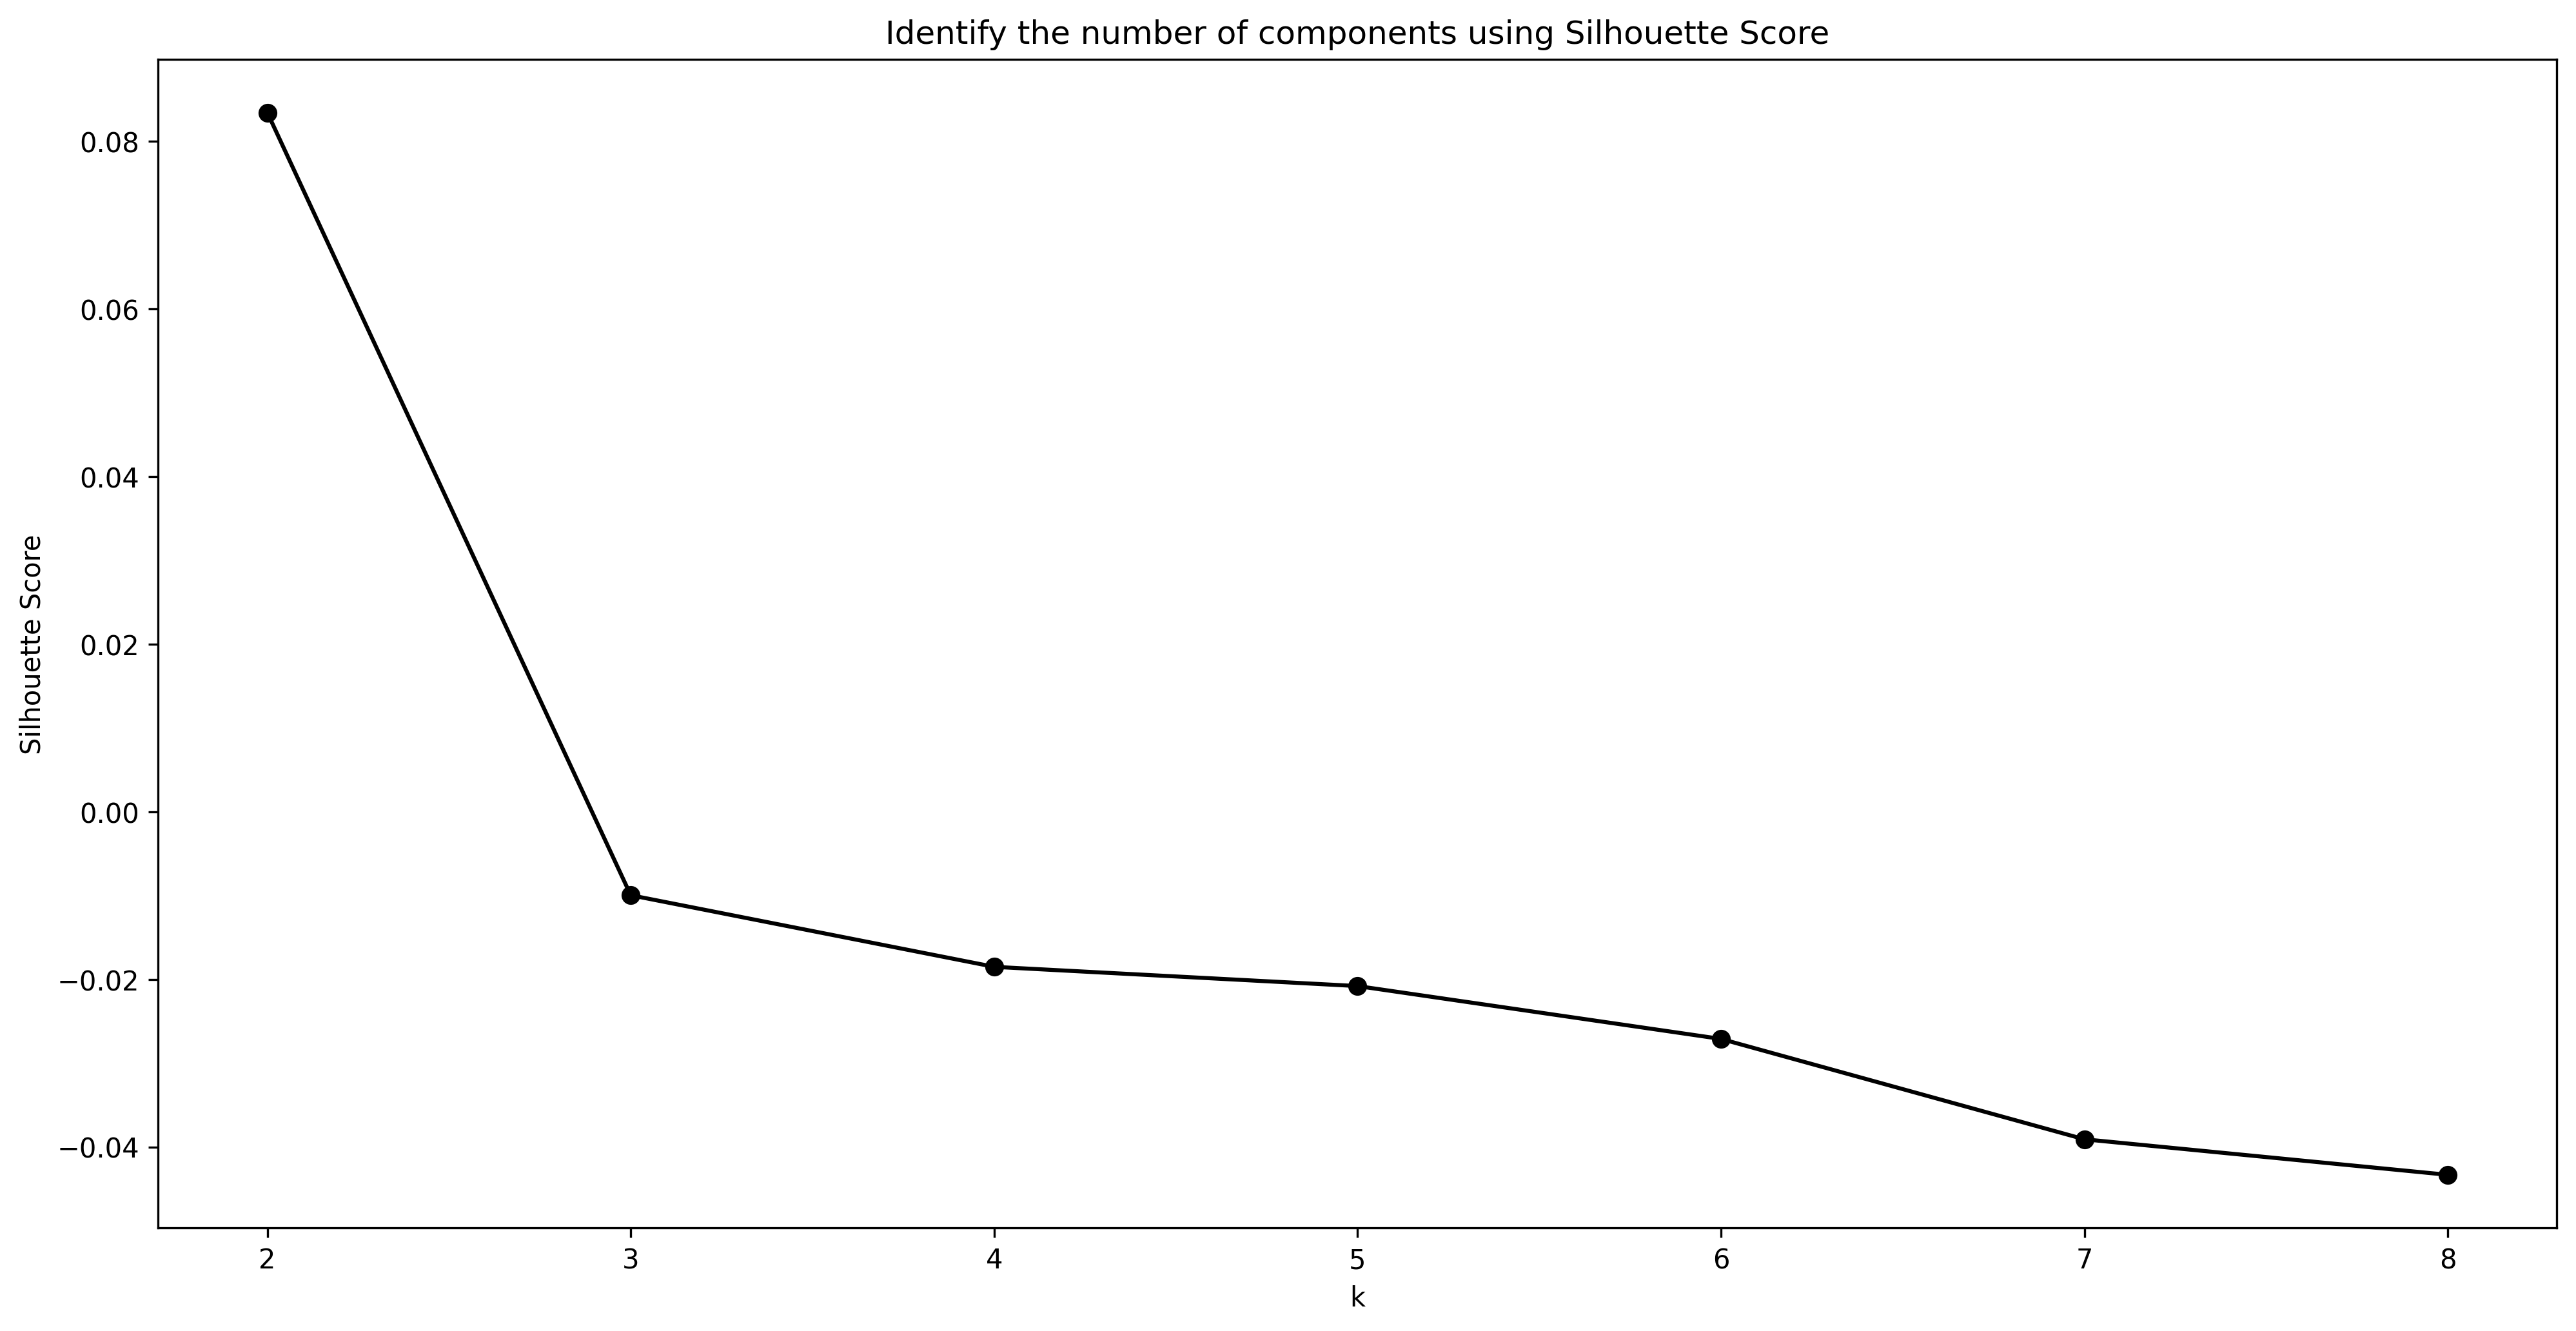

In [ ]:
# Create empty list
S=[]

# Range of clusters to try (2 to 8)
K=range(2,9)

# Select data for clustering model
X = mfcc_f

for k in K:
    # Set the model and its parameters
    model = mixture.GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))
    print(k)

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of components using Silhouette Score')
plt.show()